<a href="https://colab.research.google.com/github/Md-Thahir/AI-Tools-Lab/blob/main/SpectraLume.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Please upload the model files (prototxt, caffemodel, and pts_in_hull.npy) and the image files.


Saving 13.jpeg to 13 (1).jpeg
Loading the neural network model...
Neural network loaded successfully.
Processing the image: 13 (1).jpeg


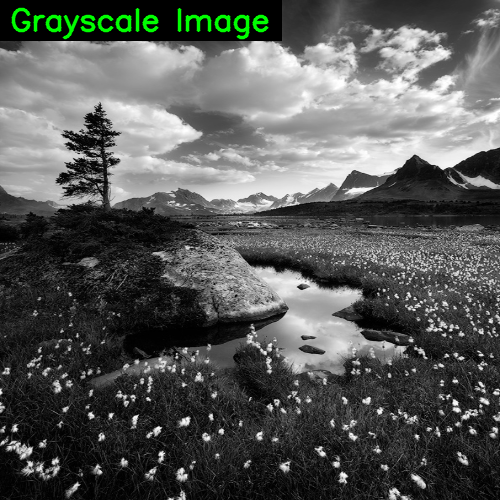

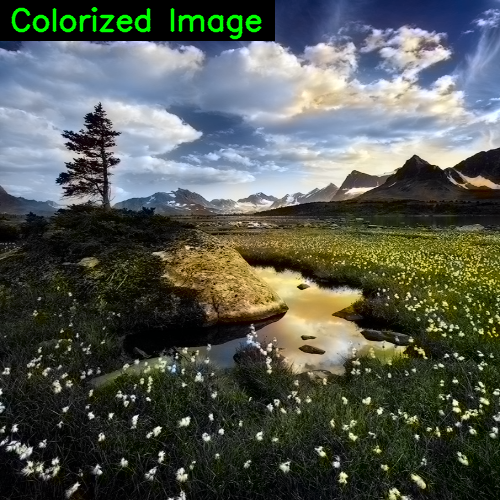

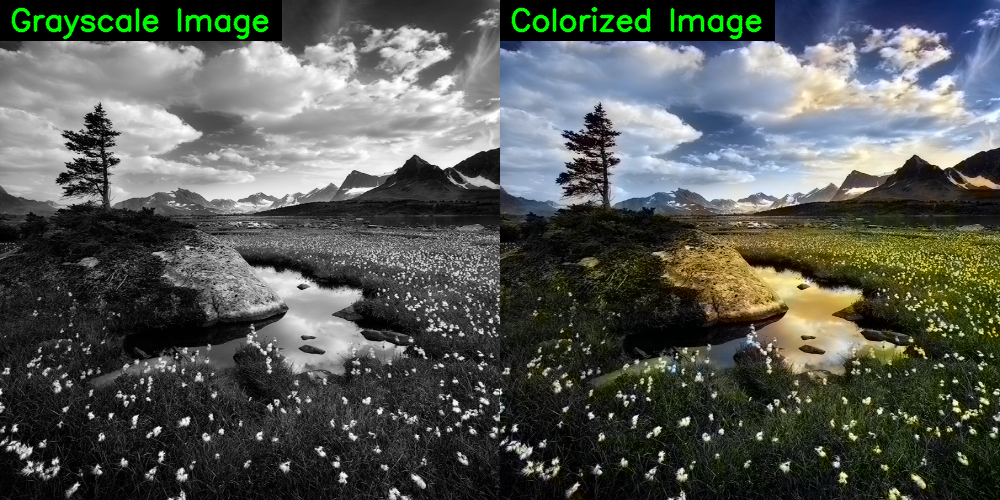

Merged image with labels saved as /content/merged_13 (1).jpeg
You can download the merged image with labels using the link below:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [36]:
import numpy as np
import cv2
from google.colab import files
from google.colab.patches import cv2_imshow

# Upload the model files and the input images
print("Please upload the model files (prototxt, caffemodel, and pts_in_hull.npy) and the image files.")
uploaded_files = files.upload()

# Update the paths based on the uploaded model files
prototxt_path = '/content/drive/MyDrive/Project/SpectraLume/Models/colorization_deploy_v2.prototxt'
model_path = '/content/drive/MyDrive/Project/SpectraLume/Models/colorization_release_v2.caffemodel'
kernel_path = '/content/drive/MyDrive/Project/SpectraLume/Models/pts_in_hull.npy'

#Assuming the image file was uploaded, use the uploaded image's filename
#image_name = list(uploaded_files.keys())[0]

# Load the neural network model
print("Loading the neural network model...")
net = cv2.dnn.readNetFromCaffe(prototxt_path, model_path)
points = np.load(kernel_path)

# Prepare the kernel (cluster centers)
points = points.transpose().reshape(2, 313, 1, 1)
net.getLayer(net.getLayerId("class8_ab")).blobs = [points.astype(np.float32)]
net.getLayer(net.getLayerId("conv8_313_rh")).blobs = [
    np.full(
        [1, 313],         # shape: 1 row and 313 columns
        2.606,            # fill_value: the constant value to fill the array with
        dtype="float32"   # data type of the array elements
    )
]
print("Neural network loaded successfully.")

# Process each uploaded image
for image_name in uploaded_files.keys():
    print(f"Processing the image: {image_name}")

    # Load and resize the grayscale image
    bw_image = cv2.imread(image_name)
    small_size = (500, 500)  # Target size for smaller image
    bw_image_resized = cv2.resize(bw_image, small_size)
    normalized = bw_image_resized.astype("float32") / 255.0

    # Convert the image from BGR to LAB color space
    lab = cv2.cvtColor(normalized, cv2.COLOR_BGR2LAB)

    # Resize the L channel to 224x224 as expected by the model
    resized = cv2.resize(lab, (224, 224))
    L = cv2.split(resized)[0]
    L -= 50  # Mean-centering

    # Pass the L channel to the network
    net.setInput(cv2.dnn.blobFromImage(L))
    ab = net.forward()[0, :, :, :].transpose((1, 2, 0))

    # Resize the output to the small image size
    ab = cv2.resize(ab, small_size)

    # Combine the original L channel with the predicted a*b* channels
    L = cv2.split(lab)[0]
    colorized = np.concatenate((L[:, :, np.newaxis], ab), axis=2)

    # Convert the LAB image back to BGR
    colorized = cv2.cvtColor(colorized, cv2.COLOR_LAB2BGR)
    colorized = (255.0 * colorized).astype("uint8")  # Convert to uint8

    # Function to add text label to an image
    def add_label(image, label, position=(10, 30), font_scale=1, color=(0, 255, 0), thickness=2):
        """Add a text label to an image with a background for better visibility."""
        font = cv2.FONT_HERSHEY_SIMPLEX
        (text_width, text_height), _ = cv2.getTextSize(label, font, font_scale, thickness)
        x, y = position
        # Draw a filled rectangle as background for the text
        cv2.rectangle(image, (x - 10, y - text_height - 10), (x + text_width + 10, y + 10), (0, 0, 0), -1)
        # Add text on top of the rectangle
        cv2.putText(image, label, (x, y), font, font_scale, color, thickness, cv2.LINE_AA)

    # Label images
    add_label(bw_image_resized, "Grayscale Image")
    add_label(colorized, "Colorized Image")

    # Merge the original and colorized images side by side
    merged_image = np.hstack((bw_image_resized, colorized))

    # Display the images with labels
    cv2_imshow(bw_image_resized)
    cv2_imshow(colorized)
    cv2_imshow(merged_image)

    # Save and provide a download option for the merged image
    merged_image_path = f'/content/merged_{image_name}'
    cv2.imwrite(merged_image_path, merged_image)
    print(f"Merged image with labels saved as {merged_image_path}")

    print("You can download the merged image with labels using the link below:")
    files.download(merged_image_path)
